In [1]:
import pandas
import PIL
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from IPython.display import display, Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

2024-05-26 00:15:14.713369: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 00:15:14.713433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 00:15:14.714894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data is already divided into train,test,val in the dataset and can be found in images_train_test_val folder

In [2]:
root_dir = "/kaggle/input/landuse-scene-classification/images_train_test_val"

In [3]:

# Initialize dictionaries to hold the counts
counts = {
    'train': {},
    'test': {},
    'validation': {}
}

# Function to count images in each subdirectory
def count_images_in_directory(directory):
    label_counts = {}
    total_count = 0
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            image_count = len([file for file in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, file))])
            label_counts[label] = image_count
            total_count += image_count
    return label_counts, total_count

# Count images in train, test, and validation directories
for folder in ['train', 'test', 'validation']:
    folder_path = os.path.join(root_dir, folder)
    counts[folder]['label_counts'], counts[folder]['total_count'] = count_images_in_directory(folder_path)

# Print the results
for folder in ['train', 'test', 'validation']:
    print(f"Folder: {folder}")
    print(f"Total images: {counts[folder]['total_count']}")
    print("Images per label:")
    for label, count in counts[folder]['label_counts'].items():
        print(f"  {label}: {count}")
    print()


Folder: train
Total images: 7350
Images per label:
  airplane: 350
  tenniscourt: 350
  river: 350
  denseresidential: 350
  parkinglot: 350
  storagetanks: 350
  overpass: 350
  sparseresidential: 350
  mediumresidential: 350
  intersection: 350
  baseballdiamond: 350
  runway: 350
  chaparral: 350
  freeway: 350
  beach: 350
  buildings: 350
  harbor: 350
  mobilehomepark: 350
  forest: 350
  golfcourse: 350
  agricultural: 350

Folder: test
Total images: 1050
Images per label:
  airplane: 50
  tenniscourt: 50
  river: 50
  denseresidential: 50
  parkinglot: 50
  storagetanks: 50
  overpass: 50
  sparseresidential: 50
  mediumresidential: 50
  intersection: 50
  baseballdiamond: 50
  runway: 50
  chaparral: 50
  freeway: 50
  beach: 50
  buildings: 50
  harbor: 50
  mobilehomepark: 50
  forest: 50
  golfcourse: 50
  agricultural: 50

Folder: validation
Total images: 2100
Images per label:
  airplane: 100
  tenniscourt: 100
  river: 100
  denseresidential: 100
  parkinglot: 100
  stor

## Labels

The dataset includes the following labels:

- airplane
- tenniscourt
- river
- denseresidential
- parkinglot
- storagetanks
- overpass
- sparseresidential
- mediumresidential
- intersection
- baseballdiamond
- runway
- chaparral
- freeway
- beach
- buildings
- harbor
- mobilehomepark
- forest
- golfcourse
- agricultural

## Dataset Summary

### Folder: train
- **Total images**: 7350
- **Images per label**: 350 each

### Folder: test
- **Total images**: 1050
- **Images per label**: 50 each

### Folder: validation
- **Total images**: 2100
- **Images per label**: 100 each

In [4]:
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(21, activation='softmax')(x)  # 21 classes for the dataset

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 4,001,941 (15.27 MB)

 Trainable params: 3,977,541 (15.17 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [5]:
train_dir = '/kaggle/input/landuse-scene-classification/images_train_test_val/train'
val_dir = '/kaggle/input/landuse-scene-classification/images_train_test_val/validation'

train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=batch_size, class_mode='sparse')
validation_generator = validation_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=batch_size, class_mode='sparse')

model.fit(train_generator, epochs=10, validation_data=validation_generator)


Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/230 ━━━━━━━━━━━━━━━━━━━━ 3:42:28 58s/step - accuracy: 0.0312 - loss: 3.4776

I0000 00:00:1716682580.113441    2239 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 ━━━━━━━━━━━━━━━━━━━━ 135s 335ms/step - accuracy: 0.6224 - loss: 1.4168 - val_accuracy: 0.8967 - val_loss: 0.3122
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.9795 - loss: 0.0765 - val_accuracy: 0.9481 - val_loss: 0.1439
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9966 - loss: 0.0218 - val_accuracy: 0.9733 - val_loss: 0.0752
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 157ms/step - accuracy: 0.9963 - loss: 0.0142 - val_accuracy: 0.9633 - val_loss: 0.1121
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.9814 - val_loss: 0.0589
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9990 - loss: 0.0062 - val_accuracy: 0.9829 - val_loss: 0.0535
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 158ms/step - accuracy: 0.9984 - loss: 0.0053 - val_accuracy: 0.9933 - val_loss: 0.0274
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 155ms/step - accuracy: 0.9984 - loss: 0.0060 - va

In [6]:
model.save('Land_use_Scene_Classification_MobileNetV3Large.h5')

In [7]:
test_dir = '/kaggle/input/landuse-scene-classification/images_train_test_val/test'
test_datagen = ImageDataGenerator()

# Set batch size
batch_size = 32

# Create the test data generator
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='sparse')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

Found 1050 images belonging to 21 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.9866 - loss: 0.0491
Test loss: 0.04786410555243492
Test accuracy: 0.9838095307350159


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


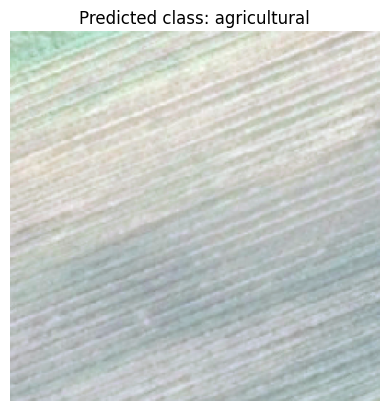

In [8]:
image_path = '/kaggle/input/landuse-scene-classification/images_train_test_val/train/agricultural/agricultural_000003.png'  # Replace with the path to your image

# Load and preprocess the input image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Perform classification
prediction = model.predict(img_array)
class_index = np.argmax(prediction)

# Define the class labels
class_labels = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings',
                'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse',
                'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 
                'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential',
                'storagetanks', 'tenniscourt']


# Get the predicted class label
predicted_class = class_labels[class_index]

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class}')
plt.show()